In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob
from os import listdir
from os.path import isfile, isdir, join
import datetime
import time
from termcolor import colored

import re
# import sys
# sys.path.insert(0, '../supermodel_test/')
from supermodel import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

%matplotlib inline
print(os.getcwd())

/home/chchinta/icg-channels


### choose supermodel formulation

In [44]:
### IMPORTANT: when specifying more than one fit function for steady-state or tau
### ss_transitions and tau_transitions: specifies how parameters of previous fit function relate to current one
### ss_identity and tau_identity: specifies how parameters of each fit function relate to the final one



if SM_NUM==1:
    ss_fit_fcn_list = [sigmoid]  # NOTE: supermodel fcns should be in the form of a list
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3]
    n_tau_params = [4,6,8]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6]]
    tau_identity = [[0,1,2,5],[0,1,2,3,5,6],np.arange(n_tau_params[-1])]

elif SM_NUM==2:
    ss_fit_fcn_list = [sigmoid,modified_sigmoid]
    n_ss_params = [2,4]
    ss_transitions = [[0,1]]
    ss_identity = [[0,1],np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3]
    n_tau_params = [4,6,8]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6]]
    tau_identity = [[0,1,2,6],[0,1,2,3,5,6],np.arange(n_tau_params[-1])]

elif SM_NUM==3:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2]
    n_tau_params = [4,6]
    tau_transitions = [[0,1,2,4]]
    tau_identity = [[0,1,2,4],np.arange(n_tau_params[-1])]

elif SM_NUM==4:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1]
    n_tau_params = [4]
    tau_identity = [np.arange(n_tau_params[-1])]

elif SM_NUM==5:
    ss_fit_fcn_list = [sigmoid]
    n_ss_params = [2]
    ss_identity = [np.arange(n_ss_params[-1])]
    tau_fit_fcn_list = [tau_fun1,tau_fun2,tau_fun3,tau_fun4]
    n_tau_params = [4,6,8,10]
    tau_transitions = [[0,1,2,4],[0,1,2,3,5,6],[0,1,2,3,4,6,7,8]]
    tau_identity = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8],np.arange(n_tau_params[-1])]
    
    
# specify error functions

def err1(data,fun,v,params):
    rmse = np.sqrt(np.mean((np.asarray(data)-np.asarray(fun(v, *params)))**2))
    stdev = np.std(np.asarray(data))
    return rmse / stdev
    
def err2(data,fun,v,params):
    P = CubicSpline(v,np.asarray(data))
    def area_diff_fun(x):
        return (P(x)-fun(x, *params))**2
    def area_fun(x):
        return P(x)**2
    x = quad(area_diff_fun,v[0],v[-1])
    x_norm = quad(area_fun,v[0],v[-1])
    return x[0] / x_norm[0]
    
def err3(data,fun,v,params):
    return np.linalg.norm(np.asarray(data)-np.asarray(fun(v, *params)))/np.linalg.norm(np.asarray(data))

In [71]:
# specify directory and load data file

iontype = "Ca"


path = "/home/chchinta/icg-channels/icg-channels-"+iontype+"/"
mod_files = [f for f in listdir(path) if isdir(join(path, f)) and 'git' not in f]
n_mod_files = len(mod_files)

# load the dict file
f = open("/home/chchinta/icg-channels/icg-channels-"+iontype+".pkl","rb")
data_dict = pickle.load(f)

# immediately save a backup just in case
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
f = open("/home/chchinta/icg-channels/backup/icg-channels-"+iontype+"-"+st+".pkl",'wb')
pickle.dump(data_dict,f)

print("Running for",iontype,"models.")
print("Number of mod files: ",n_mod_files)

Running for Ca models.
Number of mod files:  637


### main loop (runs 250-300 mod files per minute)

In [82]:
# loop through all models and fit curves

SM_NUM = 5

maxfev = 20000  # maximum number of iterations for scipy nonlinear fit fcn
sm_str = "SM"+str(SM_NUM)

for i in range(n_mod_files):
     
    mod_name = mod_files[i]    
    rate_path = path+mod_name
    # rate_files = [f for f in listdir(rate_path) if isfile(join(rate_path, f))]
    try:
        err_flags = data_dict[mod_name]['ERROR_FLAGS']
        if len(err_flags) == 0:
            rate_files = []
            valid_states = list(data_dict[mod_name]['GATES'].keys())
            for kk in valid_states:
                fs = glob(rate_path + '/*.' + kk + '*.6.3.dat')
                for fff in fs:
                    rate_files.append(fff)
    #        try:
    #            exist_rates = list(data_dict[mod_name]['RATES'].keys())  # All extracted rates
    #            for ii in valid_states:   # Only entries with gates as valid
    #                exist_rates.remove(ii)   # Remaining entries to be pruned
    #            for to_prune in exist_rates:  # Pruning the remaining rate entries
    #                data_dict[mod_name]['RATES'].pop(to_prune)
    #        except KeyError:
    #            pass

            if not data_dict[mod_name]['RATES']:
                print(colored('%d %s: rates not found.' %(i, mod_name), 'red'))
                continue

            data_dict[mod_name][sm_str+'_FIT'] = True
            data_dict[mod_name][sm_str+'_PARAMS_SS'] = {}
            data_dict[mod_name][sm_str+'_PARAMS_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR1_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR1_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR2_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR2_TAU'] = {}
            data_dict[mod_name][sm_str+'_ERROR3_SS'] = {}
            data_dict[mod_name][sm_str+'_ERROR3_TAU'] = {}
            data_dict[mod_name]['RATE_VALS_SS'] = {}
            data_dict[mod_name]['RATE_VALS_TAU'] = {}
            data_dict[mod_name]['RATE_VALS_V'] = {}

            # loop through all rate files in this mod directory
            for j in range(len(rate_files)):

                rfile = rate_files[j]
                fsplit = rfile.split(".")
                varname = fsplit[2]
                if iontype == "Ca":
                    curve_type = fsplit[4]
                else:
                    curve_type = fsplit[3]
                if varname not in data_dict[mod_name]['STATES']:   # WHY!!!?
                    data_dict[mod_name]['STATES'].append(varname)
                
                d = np.loadtxt(rfile)
                V = d[:,0]
                rate_data = d[:,1]

                if (curve_type == 'inf'):

                    if (np.max(rate_data) < 0.1 or np.min(rate_data) < 0.0 or np.std(rate_data) < 1e-6 
                        or not np.isfinite(rate_data).all()):
                        print(colored('%d %s: weird INF for rate %s' %(i, mod_name, rfile), 'magenta'))
                        data_dict[mod_name][sm_str+'_FIT'] = False
                        data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = []
                        data_dict[mod_name]['RATE_VALS_SS'][varname] = []
                        continue
                    else:
                        for k in range(len(ss_fit_fcn_list)):
                            ss_fit_fcn = ss_fit_fcn_list[k]
                            if (k==0):
                                p0 = np.random.rand(n_ss_params[k])
                                if rate_data[0] > rate_data[-1]:
                                    p0[0] *= -1.
                            else:
                                p0 = np.zeros((n_ss_params[k]))
                                p0[ss_transitions[k-1]] = popt
                            try:
                                popt, _ = curve_fit(ss_fit_fcn, V, rate_data, p0=p0, maxfev=maxfev)
                                popt_full = np.zeros((n_ss_params[-1],))
                                popt_full[ss_identity[k]] = popt
                                data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = popt_full
                                data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = err1(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = err2(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = err3(rate_data,ss_fit_fcn,V,popt)
                                data_dict[mod_name]['RATE_VALS_SS'][varname] = rate_data
                                data_dict[mod_name]['RATE_VALS_V'][varname] = V

                            except RuntimeError as err:
                                print(colored('%d %s: INF runtime error for rate %s' %(i, mod_name, rfile), 'blue'))
                                data_dict[mod_name][sm_str+'_FIT'] = False
                                data_dict[mod_name][sm_str+'_PARAMS_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR1_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR2_SS'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR3_SS'][varname] = []
                                data_dict[mod_name]['RATE_VALS_SS'][varname] = []
                                break

                elif (curve_type == 'tau'):

                    if (np.max(rate_data) < 0.001):
                        print(colored('%d %s: weird TAU for rate %s' %(i, mod_name, rfile), 'green'))
                        data_dict[mod_name][sm_str+'_FIT'] = False
                        data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = []
                        data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = []
                        data_dict[mod_name]['RATE_VALS_TAU'][varname] = []
                        continue

                    else:
                        # first fit with a straight line as a control and make sure the real fit does better
                        popt_line = np.zeros((n_tau_params[-1],))
                        popt_line[1] = np.mean(rate_data)
                        data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = popt_line
                        data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = err1(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = err2(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = err3(rate_data,tau_fit_fcn_list[-1],V,popt_line)
                        data_dict[mod_name]['RATE_VALS_TAU'][varname] = rate_data
                        data_dict[mod_name]['RATE_VALS_V'][varname] = V

                        # actual fitting
                        for k in range(len(tau_fit_fcn_list)):
                            tau_fit_fcn = tau_fit_fcn_list[k]
                            if (k==0):  # initialize differently for first fit
                                p0 = [V[np.argmax(rate_data)],np.mean(rate_data)] + [0]*(n_tau_params[k]-2)
                            else:       # use previous fit and zeros for new params
                                p0 = np.zeros((n_tau_params[k]))
                                p0[tau_transitions[k-1]] = popt
                            try:
                                popt, _ = curve_fit(tau_fit_fcn, V, rate_data, p0=p0, maxfev=maxfev)  
                                popt_full = np.zeros((n_tau_params[-1],))
                                popt_full[tau_identity[k]] = popt
                                # check if fit is better than line (using ERROR3, arbitrarily)
                                if (err3(rate_data,tau_fit_fcn,V,popt) < data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname]):  
                                    data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = popt_full
                                    data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = err1(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = err2(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = err3(rate_data,tau_fit_fcn,V,popt)
                                    data_dict[mod_name]['RATE_VALS_TAU'][varname] = rate_data
                                    data_dict[mod_name]['RATE_VALS_V'][varname] = V

                            except RuntimeError as err:
                                print(colored('%d %s: TAU runtime error for rate %s' %(i, mod_name, rfile), 'cyan'))
                                data_dict[mod_name][sm_str+'_FIT'] = False
                                data_dict[mod_name][sm_str+'_PARAMS_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR1_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR2_TAU'][varname] = []
                                data_dict[mod_name][sm_str+'_ERROR3_TAU'][varname] = []
                                data_dict[mod_name]['RATE_VALS_TAU'][varname] = []
                                break
            print('%d %s: all good.' %(i, mod_name))
        else:
            data_dict[mod_name][sm_str+'_FIT'] = False
            print('%d %s: Fix errors first' %(i, mod_name), data_dict[mod_name]['ERROR_FLAGS'])
    except KeyError:
        print('%d %s: Error flags undefined' %(i, mod_name))

# re-save data dict, and a backup copy
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')

f = open("/home/chchinta/icg-channels/backup/icg-channels-"+iontype+"-"+st+".pkl",'wb')
pickle.dump(data_dict,f)
f = open("/home/chchinta/icg-channels/icg-channels-"+iontype+".pkl",'wb')
pickle.dump(data_dict,f)

<ipython-input-44-b1d626926f08>:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  x = quad(area_diff_fun,v[0],v[-1])


0 184319_Ca_HVA.mod: all good.
1 151460_CaT.mod: Fix errors first [1]
2 135903_icaolmw.mod: Fix errors first [1]
3 39949_caL.mod: Fix errors first [5]
4 181967_cal.mod: all good.


<ipython-input-44-b1d626926f08>:67: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  x_norm = quad(area_fun,v[0],v[-1])


5 137259_cat.mod: all good.
6 185332_Can.mod: all good.
7 113446_cal2.mod: all good.
8 184182_Ca_HVA.mod: all good.
9 189154_cat.mod: all good.
10 139653_Ca_HVA.mod: all good.
11 180789_captain.mod: Fix errors first [5]
12 123815_somacar.mod: all good.
13 105385_cal_gp.mod: all good.
14 37819_IT.mod: all good.
15 101629_cal2.mod: all good.
16 143719_cat.mod: all good.
17 2733_lcafixed.mod: all good.
18 147867_cal2.mod: all good.
19 116769_car.mod: Fix errors first [8]
20 184152_Ca_HVA.mod: all good.
21 136095_IL3.mod: Fix errors first [5]
22 184299_Ca_HVA.mod: all good.
23 184337_Ca_LVA.mod: all good.
24 180789_cae.mod: Fix errors first [19]
25 122329_cap_gp.mod: all good.
26 102288_ICaT.mod: all good.
27 184145_Ca_HVA.mod: all good.
28 144401_cal.mod: all good.
29 224923_Ca_LVAst.mod: all good.
30 64229_catRT03.mod: Fix errors first [1]
31 97917_LcaMig.mod: all good.
32 184274_Ca_HVA.mod: all good.
33 135903_icapr.mod: Fix errors first [1]
34 180370_L_Ca.mod: all good.
35 169457_Ca_HV

<ipython-input-44-b1d626926f08>:58: RuntimeWarning: divide by zero encountered in double_scalars
  return rmse / stdev


77 119266_car.mod: all good.
78 137259_can2.mod: all good.
79 18198_caL3d.mod: Fix errors first [5]
80 184157_Ca_HVA.mod: all good.
81 184321_Ca_HVA.mod: all good.
82 229585_Cav3_2.mod: TAU runtime error for rate /home/chchinta/icg-channels/icg-channels-Ca/229585_Cav3_2.mod/Cav3_2.h.5e-05.tau.6.3.dat
82 229585_Cav3_2.mod: all good.
83 146565_ca.mod: all good.
84 149100_Ca_HVA.mod: all good.
85 146030_LCa3_mit_usb_ChannelML.mod: all good.
86 184301_Ca_HVA.mod: all good.
87 123927_CAl.mod: Fix errors first [5]
88 184341_Ca_HVA.mod: all good.
89 121600_il.mod: Fix errors first [5]
90 119266_cal.mod: Fix errors first [8]
91 12631_IT_wang.mod: Fix errors first [4]
92 231427_Ca_LVAst.mod: all good.
93 184166_Ca_HVA.mod: all good.
94 20212_cat_v2.mod: Fix errors first [5]
95 184142_Ca_LVA.mod: all good.
96 20212_cachan.mod: Fix errors first [5]
97 144490_cat.mod: all good.
98 184178_Ca_LVA.mod: all good.
99 143719_car.mod: all good.
100 206244_cal.mod: all good.
101 123815_cat.mod: all good.


<ipython-input-44-b1d626926f08>:58: RuntimeWarning: invalid value encountered in double_scalars
  return rmse / stdev


116 3533_cat_thal.mod: all good.
117 108458_CaT.mod: all good.
118 146026_SlowCa.mod: all good.
119 184327_Ca_HVA.mod: all good.
120 19591_CaHVA_chan.mod: all good.
121 184202_Ca_LVA.mod: all good.
122 19920_ca_a1g.mod: TAU runtime error for rate /home/chchinta/icg-channels/icg-channels-Ca/19920_ca_a1g.mod/cat1g.n.5e-05.tau.6.3.dat
122 19920_ca_a1g.mod: TAU runtime error for rate /home/chchinta/icg-channels/icg-channels-Ca/19920_ca_a1g.mod/cat1g.l.5e-05.tau.6.3.dat
122 19920_ca_a1g.mod: all good.
123 155057_can.mod: Fix errors first [4]
124 45539_cat_a.mod: all good.
125 144482_cat.mod: all good.
126 184152_Ca_LVA.mod: all good.
127 127021_Golgi_Ca_HVA.mod: all good.
128 184339_Ca_HVA.mod: all good.
129 123897_ca.mod: all good.
130 231427_Ca_HVA.mod: all good.
131 151458_caL.mod: Fix errors first [5]
132 136095_ntt.mod: all good.
133 184148_Ca_HVA.mod: all good.
134 144482_ca.mod: all good.
135 184348_Ca_LVA.mod: all good.
136 19491_N_Ca.mod: all good.
137 3817_IT.mod: all good.
138 12

330 223649_cat.mod: all good.
331 150551_cat.mod: all good.
332 123453_Cav2.mod: Fix errors first [5]
333 19920_ca_a1h.mod: Fix errors first [19]
334 187603_it2.mod: all good.
335 151685_ca.mod: all good.
336 112546_cat.mod: all good.
337 138382_CaT3_1_DP.mod: Fix errors first [5]
338 206244_car.mod: all good.
339 135902_icapr.mod: Fix errors first [1]
340 20212_My_can.mod: TAU runtime error for rate /home/chchinta/icg-channels/icg-channels-Ca/20212_My_can.mod/mycan.m.5e-05.tau.6.3.dat
340 20212_My_can.mod: all good.
341 150284_car.mod: Fix errors first [5]
342 144490_car_mag.mod: Fix errors first [1]
343 127388_pSTN_icgCA2.mod: Fix errors first [4]
344 184333_Ca_LVA.mod: all good.
345 83344_it2.mod: all good.
346 115356_CAl.mod: Fix errors first [5]
347 225311_Ca_HVA.mod: all good.
348 151126_cal.mod: all good.
349 82849_hva.mod: all good.
350 184231_Ca_HVA.mod: all good.
351 184352_Ca_HVA.mod: all good.
352 123815_car.mod: all good.
353 127388_pSTN.mod: Fix errors first [4]
354 3457_

541 182797_ICaT.mod: all good.
542 125152_CAl.mod: Fix errors first [5]
543 126637_CaP2cvode.mod: all good.
544 137259_cal2.mod: all good.
545 151126_car.mod: all good.
546 144450_can.mod: Fix errors first [4]
547 48332_cap.mod: Fix errors first [5]
548 84589_can.mod: Fix errors first [1]
549 185858_icalts.mod: Fix errors first [1]
550 149000_CaP2.mod: Fix errors first [4]
551 84612_cachan.mod: Fix errors first [7]
552 87284_can2.mod: all good.
553 20212_cat.mod: all good.
554 116862_ntt.mod: all good.
555 18501_spike.mod: Fix errors first [8]
556 121060_chan_CaQ.mod: Fix errors first [5]
557 126637_CaEcvode.mod: Fix errors first [19]
558 230326_Ca_HVA.mod: all good.
559 126637_CaP2.mod: Fix errors first [4]
560 155157_IT_huguenard.mod: all good.
561 125857_cacurrent.mod: Fix errors first [5]
562 118986_cat.mod: all good.
563 83547_calcha.mod: Fix errors first [7]
564 144523_CaLVA.mod: Fix errors first [5]
565 184274_Ca_LVA.mod: all good.
566 112834_car.mod: Fix errors first [5]
567 18

In [70]:
# print summary results

err_num = 3
err_str = 'ERROR'+str(err_num)
ss_errors = [list(data_dict[x][sm_str+'_'+err_str+'_SS'].values()) for x in data_dict.keys() 
             if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_errors = [item for sublist in ss_errors for item in sublist]

tau_errors = [list(data_dict[x][sm_str+'_'+err_str+'_TAU'].values()) for x in data_dict.keys()
              if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'] and not data_dict[x]['ERROR_FLAGS'])]
tau_errors = [item for sublist in tau_errors for item in sublist]

print('SS errors: ',np.mean(ss_errors),np.var(ss_errors))
print('TAU errors: ',np.mean(tau_errors),np.var(tau_errors))
skipped_files = [x for x in data_dict.keys() if not data_dict[x]['RATES']]
print('Nr skipped mod files: ', len(skipped_files))
nofit_files = [x for x in data_dict.keys() if (data_dict[x]['RATES'] and not data_dict[x][sm_str+'_FIT'])]
print('Nr unfitted mod files: ', len(nofit_files))

SS errors:  nan nan
TAU errors:  nan nan
Nr skipped mod files:  173
Nr unfitted mod files:  19


/home/chchinta/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chchinta/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/chchinta/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/chchinta/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/chchinta/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### unused code

In [32]:
## also get params and data (for plotting)
ss_popt = [list(data_dict[x][sm_str+'_PARAMS_SS'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_popt = [item for sublist in ss_popt for item in sublist]
tau_popt = [list(data_dict[x][sm_str+'_PARAMS_TAU'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
tau_popt = [item for sublist in tau_popt for item in sublist]
ss_data = [list(data_dict[x]['RATE_VALS_SS'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
ss_data = [item for sublist in ss_data for item in sublist]
tau_data = [list(data_dict[x]['RATE_VALS_TAU'].values()) for x in data_dict.keys() if (data_dict[x]['RATES'] and data_dict[x][sm_str+'_FIT'])]
tau_data = [item for sublist in tau_data for item in sublist]

## plotting: steady-state curves

Text(0, 0.5, 'Number of models')

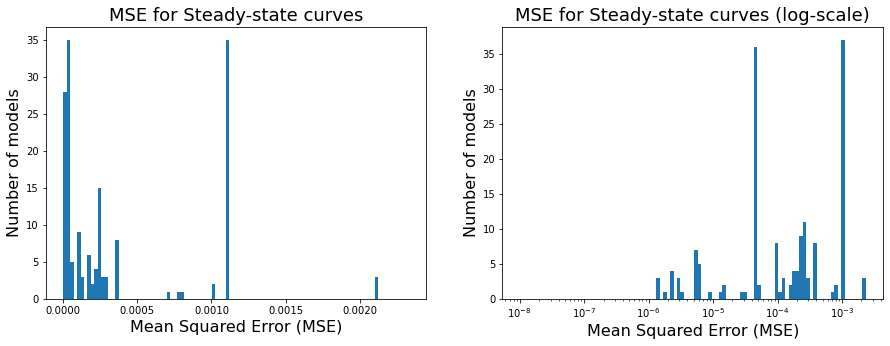

<Figure size 720x360 with 0 Axes>

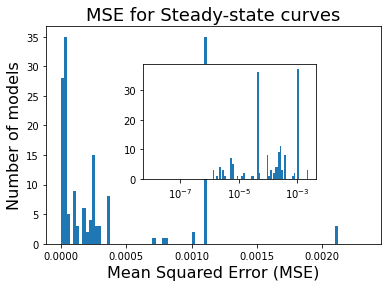

In [33]:
maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
h = plt.hist(ss_errors,range=(0,maxrange),bins=100)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.subplot(1,2,2)
h = plt.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
plt.gca().set_xscale("log")
plt.title('MSE for Steady-state curves (log-scale)',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.35, 0.35, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
h = ax1.hist(ss_errors,range=(0,maxrange),bins=100)
h = ax2.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2.set_xscale("log")
plt.sca(ax1)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)


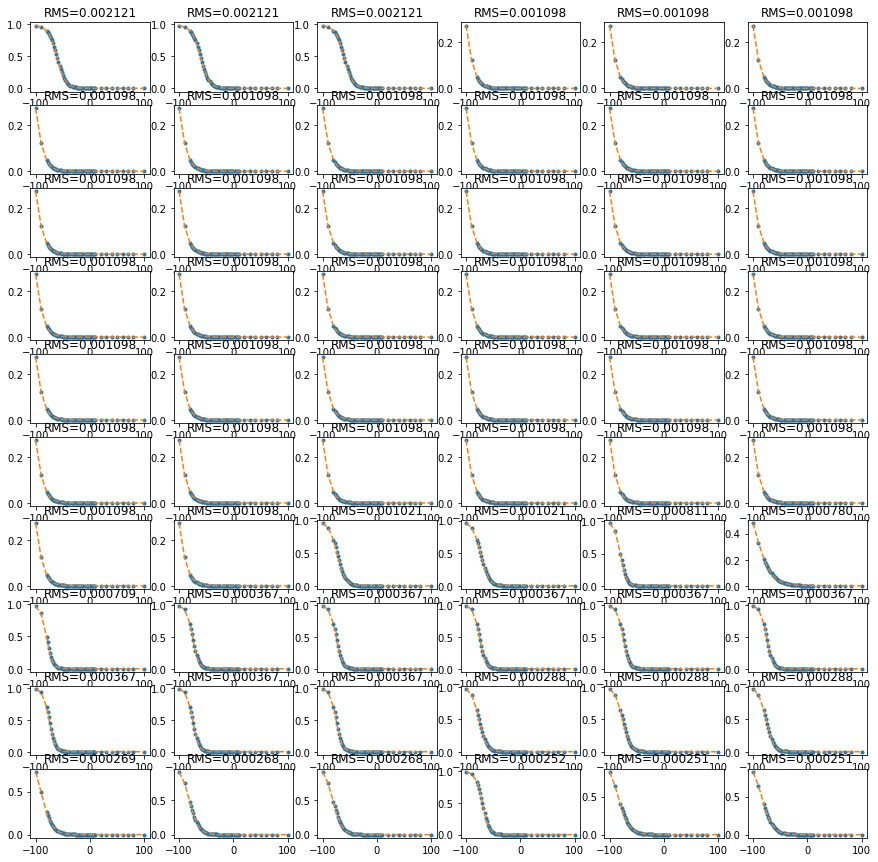

In [34]:
# plot some individual examples - arranged from worst to best

ss_inds = np.flip(np.array(ss_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(0,60):
    ind = ss_inds[i]
    popt = ss_popt[ind]
    data = ss_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, ss_fit_fcn_list[-1](V, *popt), '--')
    plt.title('RMS=%f' % ss_errors[ind])
    c += 1


## plotting: time constant curves

Text(0, 0.5, 'Number of models')

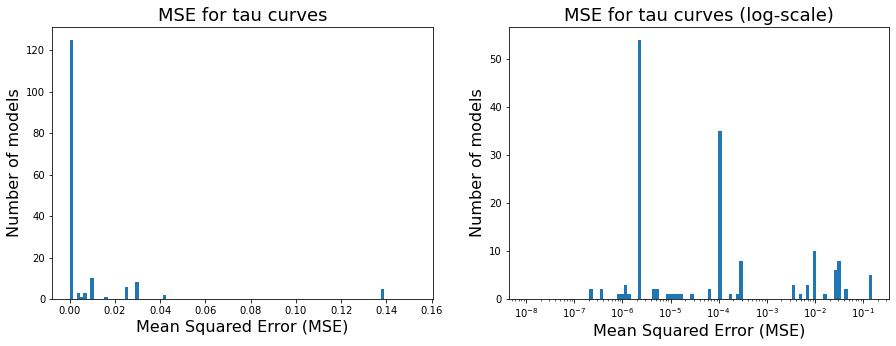

<Figure size 720x360 with 0 Axes>

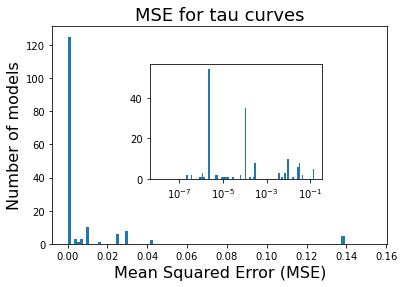

In [35]:
maxrange = 1.1*np.max(tau_errors)
maxval = 1.1*np.max(tau_errors)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
h = plt.hist(tau_errors,range=(0,maxrange),bins=100)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.subplot(1,2,2)
h = plt.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
plt.gca().set_xscale("log")
plt.title('MSE for tau curves (log-scale)',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()
left, bottom, width, height = [0.35, 0.35, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
h = ax1.hist(tau_errors,range=(0,maxrange),bins=100)
h = ax2.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2.set_xscale("log")
plt.sca(ax1)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
/home/chchinta/icg-channels/supermodel.p

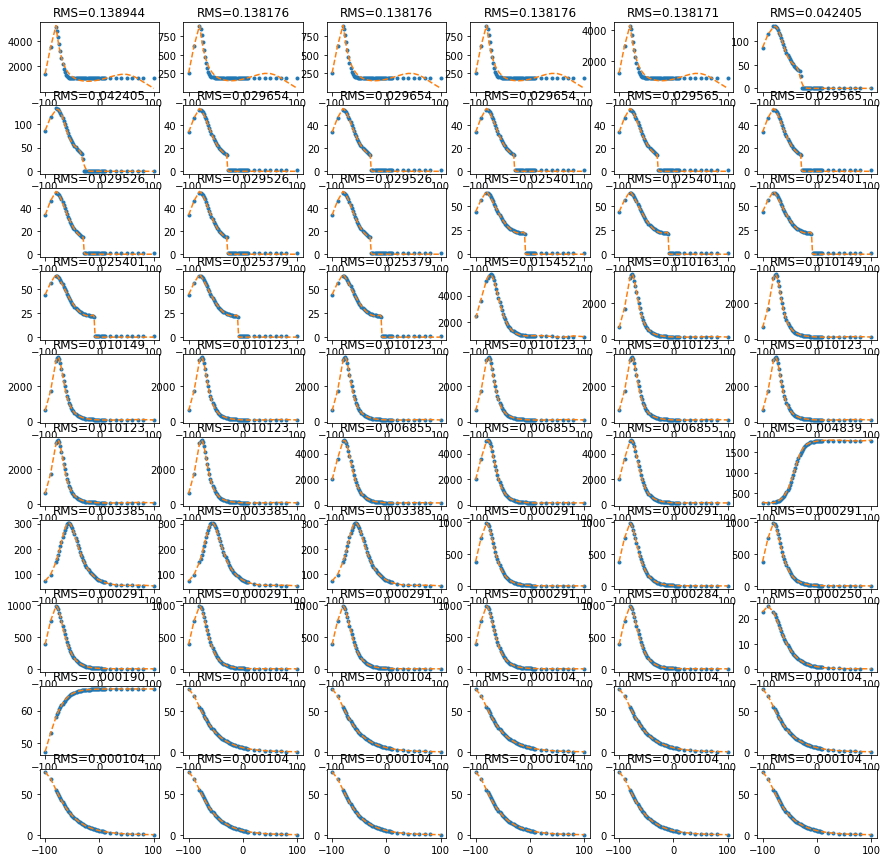

In [36]:
# plot some individual examples - arranged from worst to best

tau_inds = np.flip(np.array(tau_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(0,60):
    ind = tau_inds[i]
    popt = tau_popt[ind]
    data = tau_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, tau_fit_fcn_list[-1](V, *popt), '--')
    plt.title('RMS=%f' % tau_errors[ind])
    c += 1


# Publication figures - Fig 2

/home/chchinta/icg-channels/supermodel.py:20: RuntimeWarning: overflow encountered in exp
  return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))
<ipython-input-37-26a31fc0e40b>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


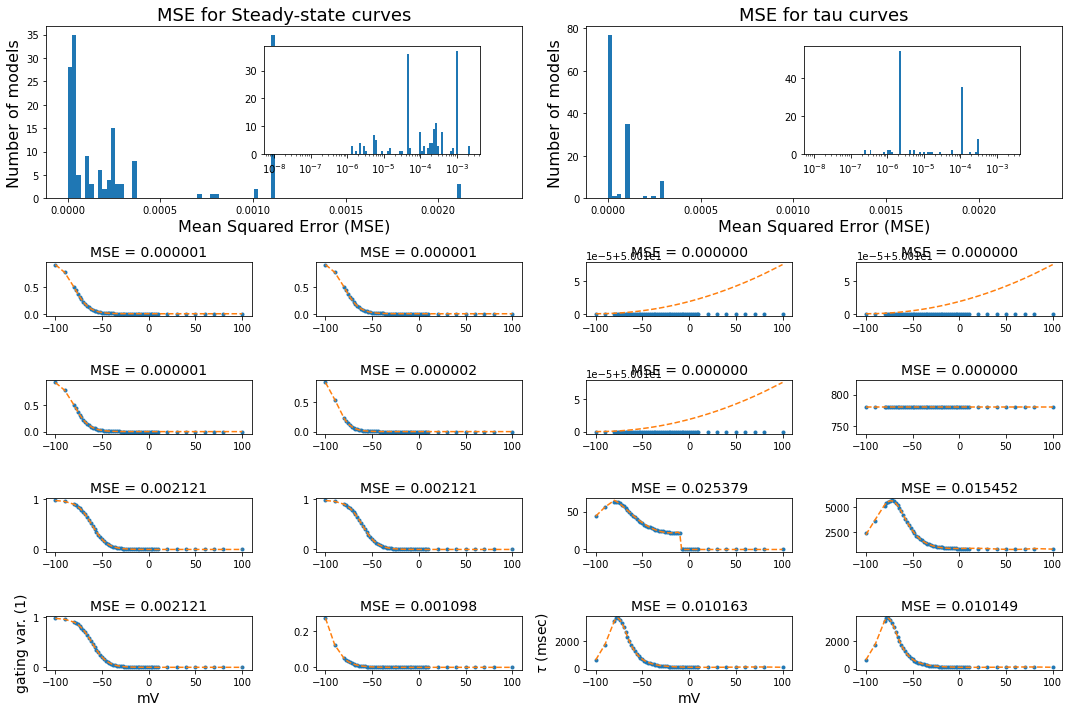

In [37]:
# SS INF curves

maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

#fig, axes = plt.subplots(2,2,figsize=(15,10))
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
h = ax1.hist(ss_errors,range=(0,maxrange),bins=100)
plt.sca(ax1)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

# plot the good and bad fits

(r,c) = (2,0)
n = 1
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[-n]
        popt = ss_popt[ind]
        data = ss_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, modified_sigmoid(V, *popt), '--')
        plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 0

(r,c) = (4,0)
n = 0
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[n]
        popt = ss_popt[ind]
        data = ss_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, modified_sigmoid(V, *popt), '--')
        plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        if r==5 and c==0:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel('gating var. (1)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 0

# TAU

maxrange = 1.1*np.max(ss_errors)
maxval = 1.1*np.max(ss_errors)

ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
h = ax2.hist(tau_errors,range=(0,maxrange),bins=100)
plt.sca(ax2)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)

# plot the good and bad fits

(r,c) = (2,2)
n = 1
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[-n]
        popt = tau_popt[ind]
        data = tau_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, tau_fit_fcn_list[-1](V, *popt), '--')
        plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

(r,c) = (4,2)
n = 20
for i in range(2):
    for j in range(2):
        plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[n]
        popt = tau_popt[ind]
        data = tau_data[ind]
        plt.plot(V,data, '.')
        plt.plot(V, tau_fit_fcn_list[-1](V, *popt), '--')
        plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        if r==5 and c==2:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel(r'$\tau$ (msec)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

# Insets

left, bottom, width, height = [0.25, 0.78, 0.2, 0.15]
ax1in = fig.add_axes([left, bottom, width, height])
h = ax1in.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax1in.set_xscale("log")

left, bottom, width, height = [0.75, 0.78, 0.2, 0.15]
ax2in = fig.add_axes([left, bottom, width, height])
h = ax2in.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100))
ax2in.set_xscale("log")

plt.tight_layout()
fig.savefig("foo.pdf", bbox_inches='tight')
